In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [177]:
def relu(Z):
    """
    Rectified Linear Unit (relu Function) x if x > 0 else x

    :param Z: input tensor
    :return:  Relu output,  and input stored in cache
    """
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid(Z):
    """
    Sigmoid Function

    :param Z: input tensor
    :return: Sigmoid output and input stored in cache
    """

    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    """
    Derivative of relu function

    :param dA:
    :param cache:
 
    :return:
    """

    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


def sigmoid_backward(dA, cache):
    """
    Derivative of sigmoid function

    :param dA:
    :param cache:
    
    :return:
    """
    Z = cache

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)
    return dZ



In [178]:
def init_weights(n_x, n_h1, n_h2, n_y):
    """

    Initialize weights tensor

    :param n_x: size of the input layer
    :param n_h1: size of the hidden layer 1
    :param n_h2: size of the hidden layer 2
    :param n_y: size of the output layer

    :return:     weights -- python dictionary containing initialized weights:
                    W1 -- weight matrix of shape (n_h1, n_x)
                    b1 -- bias vector of shape (n_h1, 1)
                    W2 -- weight matrix of shape (n_h2, n_h1)
                    b2 -- bias vector of shape (n_h2, 1)
                    W3 -- weight matrix of shape (n_y, n_h2)
                    b3 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))

    assert (W1.shape == (n_h1, n_x))
    assert (b1.shape == (n_h1, 1))
    assert (W2.shape == (n_h2, n_h1))
    assert (b2.shape == (n_h2, 1))
    assert (W3.shape == (n_y, n_h2))
    assert (b3.shape == (n_y, 1))

    weights = {
            "W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2,
            "W3": W3,
            "b3": b3
    }

    return weights


In [179]:
def step_forward(A, W, b, activation_function):
    """
    Step forward one layer in a deep neural network

    :param A: Input tensor for the layer
    :param W: Weight tensor for the layer
    :param b: Bias tensor for the layer
    :param activation_function: Activation function to be applied to the layer

    :return: Output Activation tensor and inputs stored in cache
    """

    Z = np.matmul(W, A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    linear_cache = (A, W, b)

    A_next, activation_cache = activation_function(Z)

    assert (A_next.shape == (W.shape[0], A_next.shape[1]))
    cache = (linear_cache, activation_cache)

    return A_next, cache


def compute_cost(AL, Y):
    """

    Cross Entropy Error (Cost) between Y-Hat and Y  (Y-Hat is activation of Lth Layer hence AL)

    :param AL: Activation of Lth Layer i.e Y-Hat
    :param Y: Actual Labels (Ground Truth)

    :return: Cost (How close are we?)

    """
    m = Y.shape[1]
    cost = -(np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))) / m
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def step_backward(dA, cache, activation_function_backward):
    """
    Step back one layer in deep neural network,
    i.e Find out how much adjustment is needed in weights in this layer

    :param dA:
    :param cache:
    :param activation_function_backward:
    :return:
    """

    linear_cache, activation_cache = cache

    dZ = activation_function_backward(dA, activation_cache)

    A_prev, W, b = linear_cache
    N = A_prev.shape[1]

    dW = np.matmul(dZ, A_prev.transpose()) / N
    db = np.sum(dZ, axis=1, keepdims=True) / N
    dA_prev = np.matmul(W.transpose(), dZ)


    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

def update_weights(weights, grads, learning_rate):
    """
    Update weights across all layers
    After our back-propogation we know how much weight & bias adjustment is needed
    in each layer, This function performs that update.

    :param weights: Original weights
    :param grads: Changes that needs to be made to weights
    :param learning_rate: learning rate of algorithm. (a step length in gradient descent)

    :return: updated weigths
    """
    L = len(weights)//2    # number of layers in the neural network

    for l in range(L):
        weights["W" + str(l + 1)] = weights["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        weights["b" + str(l + 1)] = weights["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return weights


In [180]:
def nn_3_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=10000, print_cost=False):

    np.random.seed(1)
    grads = {}
    costs = []  # to keep track of the cost
    m = X.shape[1]  # number of examples
    
    (n_x, n_h1, n_h2, n_y) = layers_dims

    weights = init_weights(n_x, n_h1, n_h2, n_y)

    # gradient descent
    for i in range(0, num_iterations):

        # Forward propagation: (LINEAR -> RELU) * 2 -> LINEAR -> SIGMOID.

        # Retrieve W1, b1, W2, b2 from weights
        W1 = weights["W1"]
        b1 = weights["b1"]
        W2 = weights["W2"]
        b2 = weights["b2"]
        W3 = weights["W3"]
        b3 = weights["b3"]


        A1, cache1 = step_forward(X, W1, b1, relu)
        A2, cache2 = step_forward(A1, W2, b2, relu)
        A3, cache3 = step_forward(A2, W3, b3, sigmoid)

        cost = compute_cost(A3, Y)

        # Initializing backward propagation
        dA3 = - (np.divide(Y, A3) - np.divide(1 - Y, 1 - A3))

        # Backward propagation.
        dA2, dW3, db3 = step_backward(dA3, cache3, sigmoid_backward)
        dA1, dW2, db2 = step_backward(dA2, cache2, relu_backward)
        dA0, dW1, db1 = step_backward(dA1, cache1, relu_backward)

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        grads['dW3'] = dW3
        grads['db3'] = db3


        # Update weights.
        weights = update_weights(weights, grads, learning_rate)


        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return weights


len of data = 1797
1797
dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


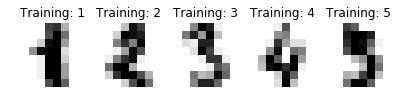

In [181]:
digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))
print(f'len of data = {len(digits.data)}')
print(len(images_and_labels))
plt.figure(figsize=(8,6))
for index, (image, label) in enumerate(images_and_labels[1:6]):
    plt.subplot(1, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

print(digits.keys())
# print(digits['DESCR'])
# print(len(digits['data'][0]))
# print(len(digits['data']))
# print(digits['data'][0])

In [182]:
# Preparing the digits dataset
N = len(digits.data)
X = digits.data
encoder = preprocessing.OneHotEncoder()
target_temp = digits.target.reshape(-1,1)
encoder.fit(target_temp)
Y = encoder.transform(target_temp).toarray()


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)
Y_train = np.transpose(Y_train)
Y_test = np.transpose(Y_test)


Cost after iteration 0: 6.9337754140142325
Cost after iteration 100: 3.271578220322025
Cost after iteration 200: 3.270022413903926
Cost after iteration 300: 3.268442260472516
Cost after iteration 400: 3.2663557672959245
Cost after iteration 500: 3.262618494692561
Cost after iteration 600: 3.253073909194501
Cost after iteration 700: 3.213067053157645
Cost after iteration 800: 2.9276733467399394
Cost after iteration 900: 2.4317231059329805
Cost after iteration 1000: 2.0726213697042954
Cost after iteration 1100: 1.9189583478394585
Cost after iteration 1200: 1.7711967482362891
Cost after iteration 1300: 1.579725180166698
Cost after iteration 1400: 1.2846667673705825
Cost after iteration 1500: 1.0648440070615577
Cost after iteration 1600: 0.9285833654590022
Cost after iteration 1700: 0.8290576218131815
Cost after iteration 1800: 0.7482595022039127
Cost after iteration 1900: 0.6776640318118191
Cost after iteration 2000: 0.6158503297715262
Cost after iteration 2100: 0.5614767850562544
Cost af

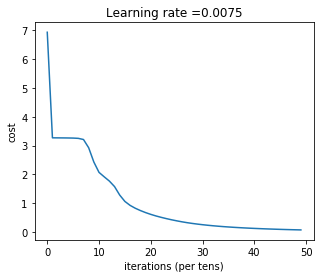

In [183]:
n_x = 64
n_h1 = 40
n_h2 = 30
n_y = 10
layers_dims = (n_x, n_h1, n_h2, n_y)

weights = nn_3_layer_model(X_train, Y_train, layers_dims = (n_x, n_h1, n_h2, n_y), num_iterations = 5000, print_cost=True)

In [184]:
accuracy_train = compute_accuracy(X_train, Y_train, weights)
accuracy_test = compute_accuracy(X_test, Y_test, weights)

Accuracy: 0.9850374064837906
Accuracy: 0.9124579124579124


In [185]:
# X_test[:,[1]]
ax_test = X_test[:, [19, 55, 300]]
ay_test = Y_test[:, [19, 55, 300]]
print(ay_test)
predict(ax_test, weights)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])